In [281]:
library(Seurat)
library(Signac)
library(ggplot2)
library(BSgenome.Hsapiens.UCSC.hg19)
library(RColorBrewer)
library(pheatmap)
library(tidyverse)
set.seed(1234)
library(dplyr)
library(cowplot)

library(chromVAR)
library(JASPAR2020)
library(TFBSTools)
library(motifmatchr)

In [2]:
top_n = 20

In [3]:
plots_dir = "../../plots/chromVAR/feature_plots"
dir.create(plots_dir, recursive = T, showWarnings = F)

In [290]:
list_use = data.frame(
    "gene" = c('HNF4A','HNF4G','PPARA','PPARG','ESRRG','ESRRA','NR4A2','CEBPD'),
    "max_rna" = c(3,    3,      3,      3,      3,      3,      3,      3),
    "max_motif" = c(3,    3,      3,      3,      3,      3,      3,      3)
         )

### load wnn object

In [5]:
Sys.time()
load("../../processed_data/wnn/20221221_324701_cells_wnn.RData")
Sys.time()

[1] "2023-07-07 12:35:25 CDT"

[1] "2023-07-07 12:39:34 CDT"

In [6]:
ls()

[1] "level.novaseq"                    "level.novaseq.renal_region_new"  
 [3] "level.novaseq.rna"                "list_use"                        
 [5] "novaseq.wnn"                      "palette.novaseq"                 
 [7] "palette.novaseq.renal_region_new" "palette.novaseq.rna"             
 [9] "plots_dir"                        "top_n"

In [7]:
novaseq = novaseq.wnn
novaseq

An object of class Seurat 
237522 features across 324701 samples within 2 assays 
Active assay: peaks (189184 features, 189184 variable features)
 1 other assay present: RNA
 6 dimensional reductions calculated: pca, harmony_RNA, lsi, harmony_peaks, umap.peaks, WNN.UMAP

In [8]:
Idents(novaseq) = 'celltype5_rna'
head(Idents(novaseq))

R1.034,R2.082,R3.082,P1.76,B3 R1.047,R2.073,R3.003,P1.65,B2 
                          tL1                           PEC 
R1.025,R2.080,R3.017,P1.66,B2 R1.056,R2.038,R3.008,P1.48,B2 
                    PT_dediff                          TAL1 
R1.089,R2.082,R3.024,P1.14,B1 R1.031,R2.072,R3.075,P1.78,B3 
                          CNT                          TAL2 
29 Levels: JGA POD PEC PT PT_dediff PT_VCAM1 tL1 tL2 tL-TAL TAL1 TAL2 ... BT

### load chromvar assay and da_motifs (DE chromVAR motif score)

In [9]:
load("../../processed_data/chromVAR/multiome_chromvar_assay_and_DEmotif_minpct0.1_padj0.01.RData")

In [10]:
ls()

[1] "chromvar_assay"                   "da_motifs"                       
 [3] "da_motifs_raw"                    "level.novaseq"                   
 [5] "level.novaseq.renal_region_new"   "level.novaseq.rna"               
 [7] "list_use"                         "novaseq"                         
 [9] "novaseq.wnn"                      "palette.novaseq"                 
[11] "palette.novaseq.renal_region_new" "palette.novaseq.rna"             
[13] "plots_dir"                        "top_n"

### add chromvar assay to Seurat assay

In [11]:
novaseq[['chromvar']] = chromvar_assay

In [12]:
novaseq

An object of class Seurat 
238268 features across 324701 samples within 3 assays 
Active assay: peaks (189184 features, 189184 variable features)
 2 other assays present: RNA, chromvar
 6 dimensional reductions calculated: pca, harmony_RNA, lsi, harmony_peaks, umap.peaks, WNN.UMAP

In [13]:
if (FALSE){
    save(list = c("chromvar_assay"), file = "../../processed_data/wnn/20221221_324701_cells_JASPAR2020_chromvar.RData", compress = T)
}

### add motif object

In [14]:
if (FALSE){
    Sys.time()
    pwm_set <- getMatrixSet(x = JASPAR2020, opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)) #this is using the core vertebrate database
    Sys.time()  
    
    Sys.time()
    novaseq <- AddMotifs(
      object = novaseq,
      genome = BSgenome.Hsapiens.UCSC.hg19,
      pfm = pwm_set,
      assay = "peaks"
    )
    Sys.time()
    
    motifs = novaseq@assays$peaks@motifs
    
    save(list = c("motifs"), file = "../../processed_data/wnn/20221221_324701_cells_JASPAR2020_motifs.RData", compress = T)
}



In [15]:
load("../../processed_data/wnn/20221221_324701_cells_JASPAR2020_motifs.RData")

In [16]:
novaseq <- SetAssayData(novaseq, assay = 'peaks', slot = 'motifs', new.data = motifs)

In [274]:
SingleDimPlot <- function(
  data,
  dims,
  col.by = NULL,
  cols = NULL,
  pt.size = NULL,
  shape.by = NULL,
  alpha.by = NULL,
  order = NULL,
  label = FALSE,
  repel = FALSE,
  label.size = 4,
  cells.highlight = NULL,
  cols.highlight = '#DE2D26',
  sizes.highlight = 1,
  na.value = 'grey50',
  raster = NULL,
  raster.dpi = NULL
) {
#   pt.size <- pt.size %||% AutoPointSize(data = data, raster = raster)
  if ((nrow(x = data) > 1e5) & !isFALSE(raster)){
    message("Rasterizing points since number of points exceeds 100,000.",
            "\nTo disable this behavior set `raster=FALSE`")
  }
  raster <- raster %||% (nrow(x = data) > 1e5)
  if (!is.null(x = raster.dpi)) {
    if (!is.numeric(x = raster.dpi) || length(x = raster.dpi) != 2)
      stop("'raster.dpi' must be a two-length numeric vector")
  }
  if (length(x = dims) != 2) {
    stop("'dims' must be a two-length vector")
  }
  if (!is.data.frame(x = data)) {
    data <- as.data.frame(x = data)
  }
  if (is.character(x = dims) && !all(dims %in% colnames(x = data))) {
    stop("Cannot find dimensions to plot in data")
  } else if (is.numeric(x = dims)) {
    dims <- colnames(x = data)[dims]
  }
  if (!is.null(x = cells.highlight)) {
    if (inherits(x = cells.highlight, what = "data.frame")) {
      stop("cells.highlight cannot be a dataframe. ",
           "Please supply a vector or list")
    }
    highlight.info <- SetHighlight(
      cells.highlight = cells.highlight,
      cells.all = rownames(x = data),
      sizes.highlight = sizes.highlight %||% pt.size,
      cols.highlight = cols.highlight,
      col.base = cols[1] %||% '#C3C3C3',
      pt.size = pt.size
    )
    order <- highlight.info$plot.order
    data$highlight <- highlight.info$highlight
    col.by <- 'highlight'
    pt.size <- highlight.info$size
    cols <- highlight.info$color
  }
  if (!is.null(x = order) && !is.null(x = col.by)) {
    if (typeof(x = order) == "logical") {
      if (order) {
        data <- data[order(!is.na(x = data[, col.by]), data[, col.by]), ]
      }
    } else {
      order <- rev(x = c(
        order,
        setdiff(x = unique(x = data[, col.by]), y = order)
      ))
      data[, col.by] <- factor(x = data[, col.by], levels = order)
      new.order <- order(x = data[, col.by])
      data <- data[new.order, ]
      if (length(x = pt.size) == length(x = new.order)) {
        pt.size <- pt.size[new.order]
      }
    }
  }
  if (!is.null(x = col.by) && !col.by %in% colnames(x = data)) {
    warning("Cannot find ", col.by, " in plotting data, not coloring plot")
    col.by <- NULL
  } else {
    # col.index <- grep(pattern = col.by, x = colnames(x = data), fixed = TRUE)
    col.index <- match(x = col.by, table = colnames(x = data))
    if (grepl(pattern = '^\\d', x = col.by)) {
      # Do something for numbers
      col.by <- paste0('x', col.by)
    } else if (grepl(pattern = '-', x = col.by)) {
      # Do something for dashes
      col.by <- gsub(pattern = '-', replacement = '.', x = col.by)
    }
    colnames(x = data)[col.index] <- col.by
  }
  if (!is.null(x = shape.by) && !shape.by %in% colnames(x = data)) {
    warning("Cannot find ", shape.by, " in plotting data, not shaping plot")
  }
  if (!is.null(x = alpha.by) && !alpha.by %in% colnames(x = data)) {
    warning(
      "Cannot find alpha variable ",
      alpha.by,
      " in data, setting to NULL",
      call. = FALSE,
      immediate. = TRUE
    )
    alpha.by <- NULL
  }
  
  plot <- ggplot(data = data)
  plot <- if (isTRUE(x = raster)) {
    plot + geom_scattermore(
      mapping = aes_string(
        x = dims[1],
        y = dims[2],
        color = paste0("`", col.by, "`"),
        shape = shape.by,
        alpha = alpha.by
      ),
      pointsize = pt.size,
      pixels = raster.dpi
    )
  } else {
    plot + geom_point(
      mapping = aes_string(
        x = dims[1],
        y = dims[2],
        color = paste0("`", col.by, "`"),
        shape = shape.by,
        alpha = alpha.by,
          size = factor(pt.size),
          stroke = 0.05
      )
#       size = pt.size
    ) + scale_size_manual(values = c(pt.size, pt.size), guide = "none")
#       + scale_size_manual(values = c(pt.size, pt.size))
      
  }

  plot <- plot +
    guides(color = guide_legend(override.aes = list(size = 3))) +
    labs(color = NULL, title = col.by) +
    CenterTitle()
  if (label && !is.null(x = col.by)) {
    plot <- LabelClusters(
      plot = plot,
      id = col.by,
      repel = repel,
      size = label.size
    )
  }
  if (!is.null(x = cols)) {
    if (length(x = cols) == 1 && (is.numeric(x = cols) || cols %in% rownames(x = brewer.pal.info))) {
      scale <- scale_color_brewer(palette = cols, na.value = na.value)
    } else if (length(x = cols) == 1 && (cols %in% c('alphabet', 'alphabet2', 'glasbey', 'polychrome', 'stepped'))) {
      colors <- DiscretePalette(length(unique(data[[col.by]])), palette = cols)
      scale <- scale_color_manual(values = colors, na.value = na.value)
    } else {
      scale <- scale_color_manual(values = cols, na.value = na.value)
    }
    plot <- plot + scale
  }
  plot <- plot + theme_cowplot()
  return(plot)
}

In [260]:
FeaturePlot <- function(
  object,
  features,
  dims = c(1, 2),
  cells = NULL,
  cols = if (blend) {
    c('lightgrey', '#ff0000', '#00ff00')
  } else {
    c('lightgrey', 'blue')
  },
  pt.size = NULL,
  order = FALSE,
  min.cutoff = NA,
  max.cutoff = NA,
  reduction = NULL,
  split.by = NULL,
  keep.scale = "feature",
  shape.by = NULL,
  slot = 'data',
  blend = FALSE,
  blend.threshold = 0.5,
  label = FALSE,
  label.size = 4,
  label.color = "black",
  repel = FALSE,
  ncol = NULL,
  coord.fixed = FALSE,
  by.col = TRUE,
  sort.cell = NULL,
  interactive = FALSE,
  combine = TRUE,
  raster = NULL,
  raster.dpi = c(512, 512)
) {
  # TODO: deprecate fully on 3.2.0
  if (!is.null(x = sort.cell)) {
    warning(
      "The sort.cell parameter is being deprecated. Please use the order ",
      "parameter instead for equivalent functionality.",
      call. = FALSE,
      immediate. = TRUE
    )
    if (isTRUE(x = sort.cell)) {
      order <- sort.cell
    }
  }
  if (interactive) {
    return(IFeaturePlot(
      object = object,
      feature = features[1],
      dims = dims,
      reduction = reduction,
      slot = slot
    ))
  }
  # Check keep.scale param for valid entries
  if (!(is.null(x = keep.scale)) && !(keep.scale %in% c("feature", "all"))) {
    stop("`keep.scale` must be set to either `feature`, `all`, or NULL")
  }
  # Set a theme to remove right-hand Y axis lines
  # Also sets right-hand Y axis text label formatting
  no.right <- theme(
    axis.line.y.right = element_blank(),
    axis.ticks.y.right = element_blank(),
    axis.text.y.right = element_blank(),
    axis.title.y.right = element_text(
      face = "bold",
      size = 14,
      margin = margin(r = 7)
    )
  )
  # Get the DimReduc to use
  reduction <- reduction %||% DefaultDimReduc(object = object)
  if (length(x = dims) != 2 || !is.numeric(x = dims)) {
    stop("'dims' must be a two-length integer vector")
  }
  # Figure out blending stuff
  if (blend && length(x = features) != 2) {
    stop("Blending feature plots only works with two features")
  }
  # Set color scheme for blended FeaturePlots
  if (blend) {
    default.colors <- eval(expr = formals(fun = FeaturePlot)$cols)
    cols <- switch(
      EXPR = as.character(x = length(x = cols)),
      '0' = {
        warning(
          "No colors provided, using default colors",
          call. = FALSE,
          immediate. = TRUE
        )
        default.colors
      },
      '1' = {
        warning(
          "Only one color provided, assuming specified is double-negative and augmenting with default colors",
          call. = FALSE,
          immediate. = TRUE
        )
        c(cols, default.colors[2:3])
      },
      '2' = {
        warning(
          "Only two colors provided, assuming specified are for features and agumenting with '",
          default.colors[1],
          "' for double-negatives",
          call. = FALSE,
          immediate. = TRUE
        )
        c(default.colors[1], cols)
      },
      '3' = cols,
      {
        warning(
          "More than three colors provided, using only first three",
          call. = FALSE,
          immediate. = TRUE
        )
        cols[1:3]
      }
    )
  }
  if (blend && length(x = cols) != 3) {
    stop("Blending feature plots only works with three colors; first one for negative cells")
  }
  # Name the reductions
  dims <- paste0(Key(object = object[[reduction]]), dims)
  cells <- cells %||% colnames(x = object)
  # Get plotting data
  data <- FetchData(
    object = object,
    vars = c(dims, 'ident', features),
    cells = cells,
    slot = slot
  )
  # Check presence of features/dimensions
  if (ncol(x = data) < 4) {
    stop(
      "None of the requested features were found: ",
      paste(features, collapse = ', '),
      " in slot ",
      slot,
      call. = FALSE
    )
  } else if (!all(dims %in% colnames(x = data))) {
    stop("The dimensions requested were not found", call. = FALSE)
  }
  features <- colnames(x = data)[4:ncol(x = data)]
  # Determine cutoffs
  min.cutoff <- mapply(
    FUN = function(cutoff, feature) {
      return(ifelse(
        test = is.na(x = cutoff),
        yes = min(data[, feature]),
        no = cutoff
      ))
    },
    cutoff = min.cutoff,
    feature = features
  )
  max.cutoff <- mapply(
    FUN = function(cutoff, feature) {
      return(ifelse(
        test = is.na(x = cutoff),
        yes = max(data[, feature]),
        no = cutoff
      ))
    },
    cutoff = max.cutoff,
    feature = features
  )
  check.lengths <- unique(x = vapply(
    X = list(features, min.cutoff, max.cutoff),
    FUN = length,
    FUN.VALUE = numeric(length = 1)
  ))
  if (length(x = check.lengths) != 1) {
    stop("There must be the same number of minimum and maximum cuttoffs as there are features")
  }
  brewer.gran <- ifelse(
    test = length(x = cols) == 1,
    yes = brewer.pal.info[cols, ]$maxcolors,
    no = length(x = cols)
  )
  # Apply cutoffs
  data[, 4:ncol(x = data)] <- sapply(
    X = 4:ncol(x = data),
    FUN = function(index) {
      data.feature <- as.vector(x = data[, index])
      min.use <- SetQuantile(cutoff = min.cutoff[index - 3], data.feature)
      max.use <- SetQuantile(cutoff = max.cutoff[index - 3], data.feature)
      data.feature[data.feature < min.use] <- min.use
      data.feature[data.feature > max.use] <- max.use
      if (brewer.gran == 2) {
        return(data.feature)
      }
      data.cut <- if (all(data.feature == 0)) {
        0
      }
      else {
        as.numeric(x = as.factor(x = cut(
          x = as.numeric(x = data.feature),
          breaks = brewer.gran
        )))
      }
      return(data.cut)
    }
  )
  colnames(x = data)[4:ncol(x = data)] <- features
  rownames(x = data) <- cells
  # Figure out splits (FeatureHeatmap)
  data$split <- if (is.null(x = split.by)) {
    RandomName()
  } else {
    switch(
      EXPR = split.by,
      ident = Idents(object = object)[cells, drop = TRUE],
      object[[split.by, drop = TRUE]][cells, drop = TRUE]
    )
  }
  if (!is.factor(x = data$split)) {
    data$split <- factor(x = data$split)
  }
  # Set shaping variable
  if (!is.null(x = shape.by)) {
    data[, shape.by] <- object[[shape.by, drop = TRUE]]
  }
  # Make list of plots
  plots <- vector(
    mode = "list",
    length = ifelse(
      test = blend,
      yes = 4,
      no = length(x = features) * length(x = levels(x = data$split))
    )
  )
  # Apply common limits
  xlims <- c(floor(x = min(data[, dims[1]])), ceiling(x = max(data[, dims[1]])))
  ylims <- c(floor(min(data[, dims[2]])), ceiling(x = max(data[, dims[2]])))
  # Set blended colors
  if (blend) {
    ncol <- 4
    color.matrix <- BlendMatrix(
      two.colors = cols[2:3],
      col.threshold = blend.threshold,
      negative.color = cols[1]
    )
    cols <- cols[2:3]
    colors <- list(
      color.matrix[, 1],
      color.matrix[1, ],
      as.vector(x = color.matrix)
    )
  }
  # Make the plots
  for (i in 1:length(x = levels(x = data$split))) {
    # Figure out which split we're working with
    ident <- levels(x = data$split)[i]
    data.plot <- data[as.character(x = data$split) == ident, , drop = FALSE]
    # Blend expression values
    if (blend) {
      features <- features[1:2]
      no.expression <- features[colMeans(x = data.plot[, features]) == 0]
      if (length(x = no.expression) != 0) {
        stop(
          "The following features have no value: ",
          paste(no.expression, collapse = ', '),
          call. = FALSE
        )
      }
      data.plot <- cbind(data.plot[, c(dims, 'ident')], BlendExpression(data = data.plot[, features[1:2]]))
      features <- colnames(x = data.plot)[4:ncol(x = data.plot)]
    }
    # Make per-feature plots
    for (j in 1:length(x = features)) {
      feature <- features[j]
      # Get blended colors
      if (blend) {
        cols.use <- as.numeric(x = as.character(x = data.plot[, feature])) + 1
        cols.use <- colors[[j]][sort(x = unique(x = cols.use))]
      } else {
        cols.use <- NULL
      }
      data.single <- data.plot[, c(dims, 'ident', feature, shape.by)]
      # Make the plot
      plot <- SingleDimPlot(
        data = data.single,
        dims = dims,
        col.by = feature,
        order = order,
        pt.size = pt.size,
        cols = cols.use,
        shape.by = shape.by,
        label = FALSE,
        raster = raster,
        raster.dpi = raster.dpi
      ) +
        scale_x_continuous(limits = xlims) +
        scale_y_continuous(limits = ylims) +
        theme_cowplot() +
        CenterTitle()
        # theme(plot.title = element_text(hjust = 0.5))
      # Add labels
      if (label) {
        plot <- LabelClusters(
          plot = plot,
          id = 'ident',
          repel = repel,
          size = label.size,
          color = label.color
        )
      }
      # Make FeatureHeatmaps look nice(ish)
      if (length(x = levels(x = data$split)) > 1) {
        plot <- plot + theme(panel.border = element_rect(fill = NA, colour = 'black'))
        # Add title
        plot <- plot + if (i == 1) {
          labs(title = feature)
        } else {
          labs(title = NULL)
        }
        # Add second axis
        if (j == length(x = features) && !blend) {
          suppressMessages(
            expr = plot <- plot +
              scale_y_continuous(
                sec.axis = dup_axis(name = ident),
                limits = ylims
              ) +
              no.right
          )
        }
        # Remove left Y axis
        if (j != 1) {
          plot <- plot + theme(
            axis.line.y = element_blank(),
            axis.ticks.y = element_blank(),
            axis.text.y = element_blank(),
            axis.title.y.left = element_blank()
          )
        }
        # Remove bottom X axis
        if (i != length(x = levels(x = data$split))) {
          plot <- plot + theme(
            axis.line.x = element_blank(),
            axis.ticks.x = element_blank(),
            axis.text.x = element_blank(),
            axis.title.x = element_blank()
          )
        }
      } else {
        plot <- plot + labs(title = feature)
      }
      # Add colors scale for normal FeaturePlots
      if (!blend) {
        plot <- plot + guides(color = NULL)
        cols.grad <- cols
        if (length(x = cols) == 1) {
          plot <- plot + scale_color_brewer(palette = cols)
        } else if (length(x = cols) > 1) {
          unique.feature.exp <- unique(data.plot[, feature])
          if (length(unique.feature.exp) == 1) {
            warning("All cells have the same value (", unique.feature.exp, ") of ", feature, ".")
            if (unique.feature.exp == 0) {
              cols.grad <- cols[1]
            } else{
              cols.grad <- cols
            }
          }
          plot <- suppressMessages(
            expr = plot + scale_color_gradientn(
              colors = cols.grad,
              guide = "colorbar"
            )
          )
        }
      }
      if (!(is.null(x = keep.scale)) && keep.scale == "feature" && !blend) {
        max.feature.value <- max(data[, feature])
        min.feature.value <- min(data[, feature])
        plot <- suppressMessages(plot & scale_color_gradientn(colors = cols, limits = c(min.feature.value, max.feature.value)))
      }
      # Add coord_fixed
      if (coord.fixed) {
        plot <- plot + coord_fixed()
      }
      # I'm not sure why, but sometimes the damn thing fails without this
      # Thanks ggplot2
      plot <- plot
      # Place the plot
      plots[[(length(x = features) * (i - 1)) + j]] <- plot
    }
  }
  # Add blended color key
  if (blend) {
    blend.legend <- BlendMap(color.matrix = color.matrix)
    for (ii in 1:length(x = levels(x = data$split))) {
      suppressMessages(expr = plots <- append(
        x = plots,
        values = list(
          blend.legend +
            scale_y_continuous(
              sec.axis = dup_axis(name = ifelse(
                test = length(x = levels(x = data$split)) > 1,
                yes = levels(x = data$split)[ii],
                no = ''
              )),
              expand = c(0, 0)
            ) +
            labs(
              x = features[1],
              y = features[2],
              title = if (ii == 1) {
                paste('Color threshold:', blend.threshold)
              } else {
                NULL
              }
            ) +
            no.right
        ),
        after = 4 * ii - 1
      ))
    }
  }
  # Remove NULL plots
  plots <- Filter(f = Negate(f = is.null), x = plots)
  # Combine the plots
  if (is.null(x = ncol)) {
    ncol <- 2
    if (length(x = features) == 1) {
      ncol <- 1
    }
    if (length(x = features) > 6) {
      ncol <- 3
    }
    if (length(x = features) > 9) {
      ncol <- 4
    }
  }
  ncol <- ifelse(
    test = is.null(x = split.by) || blend,
    yes = ncol,
    no = length(x = features)
  )
  legend <- if (blend) {
    'none'
  } else {
    split.by %iff% 'none'
  }
  # Transpose the FeatureHeatmap matrix (not applicable for blended FeaturePlots)
  if (combine) {
    if (by.col && !is.null(x = split.by) && !blend) {
      plots <- lapply(
        X = plots,
        FUN = function(x) {
          return(suppressMessages(
            expr = x +
              theme_cowplot() +
              ggtitle("") +
              scale_y_continuous(sec.axis = dup_axis(name = ""), limits = ylims) +
              no.right
          ))
        }
      )
      nsplits <- length(x = levels(x = data$split))
      idx <- 1
      for (i in (length(x = features) * (nsplits - 1) + 1):(length(x = features) * nsplits)) {
        plots[[i]] <- suppressMessages(
          expr = plots[[i]] +
            scale_y_continuous(
              sec.axis = dup_axis(name = features[[idx]]),
              limits = ylims
            ) +
            no.right
        )
        idx <- idx + 1
      }
      idx <- 1
      for (i in which(x = 1:length(x = plots) %% length(x = features) == 1)) {
        plots[[i]] <- plots[[i]] +
          ggtitle(levels(x = data$split)[[idx]]) +
          theme(plot.title = element_text(hjust = 0.5))
        idx <- idx + 1
      }
      idx <- 1
      if (length(x = features) == 1) {
        for (i in 1:length(x = plots)) {
          plots[[i]] <- plots[[i]] +
            ggtitle(levels(x = data$split)[[idx]]) +
            theme(plot.title = element_text(hjust = 0.5))
          idx <- idx + 1
        }
        ncol <- 1
        nrow <- nsplits
      } else {
        nrow <- split.by %iff% length(x = levels(x = data$split))
      }
      plots <- plots[c(do.call(
        what = rbind,
        args = split(x = 1:length(x = plots), f = ceiling(x = seq_along(along.with = 1:length(x = plots)) / length(x = features)))
      ))]
      # Set ncol to number of splits (nrow) and nrow to number of features (ncol)
      plots <- wrap_plots(plots, ncol = nrow, nrow = ncol)
      if (!is.null(x = legend) && legend == 'none') {
        plots <- plots & NoLegend()
      }
    } else {
      plots <- wrap_plots(plots, ncol = ncol, nrow = split.by %iff% length(x = levels(x = data$split)))
    }
    if (!is.null(x = legend) && legend == 'none') {
      plots <- plots & NoLegend()
    }
    if (!(is.null(x = keep.scale)) && keep.scale == "all" && !blend) {
      max.feature.value <- max(data[, features])
      min.feature.value <- min(data[, features])
      plots <- suppressMessages(plots & scale_color_gradientn(colors = cols, limits = c(min.feature.value, max.feature.value)))
    }
  }
  return(plots)
}

In [261]:
library(patchwork)

Warning message:
“Could not find CEBPD in the default search locations, found in RNA assay instead”


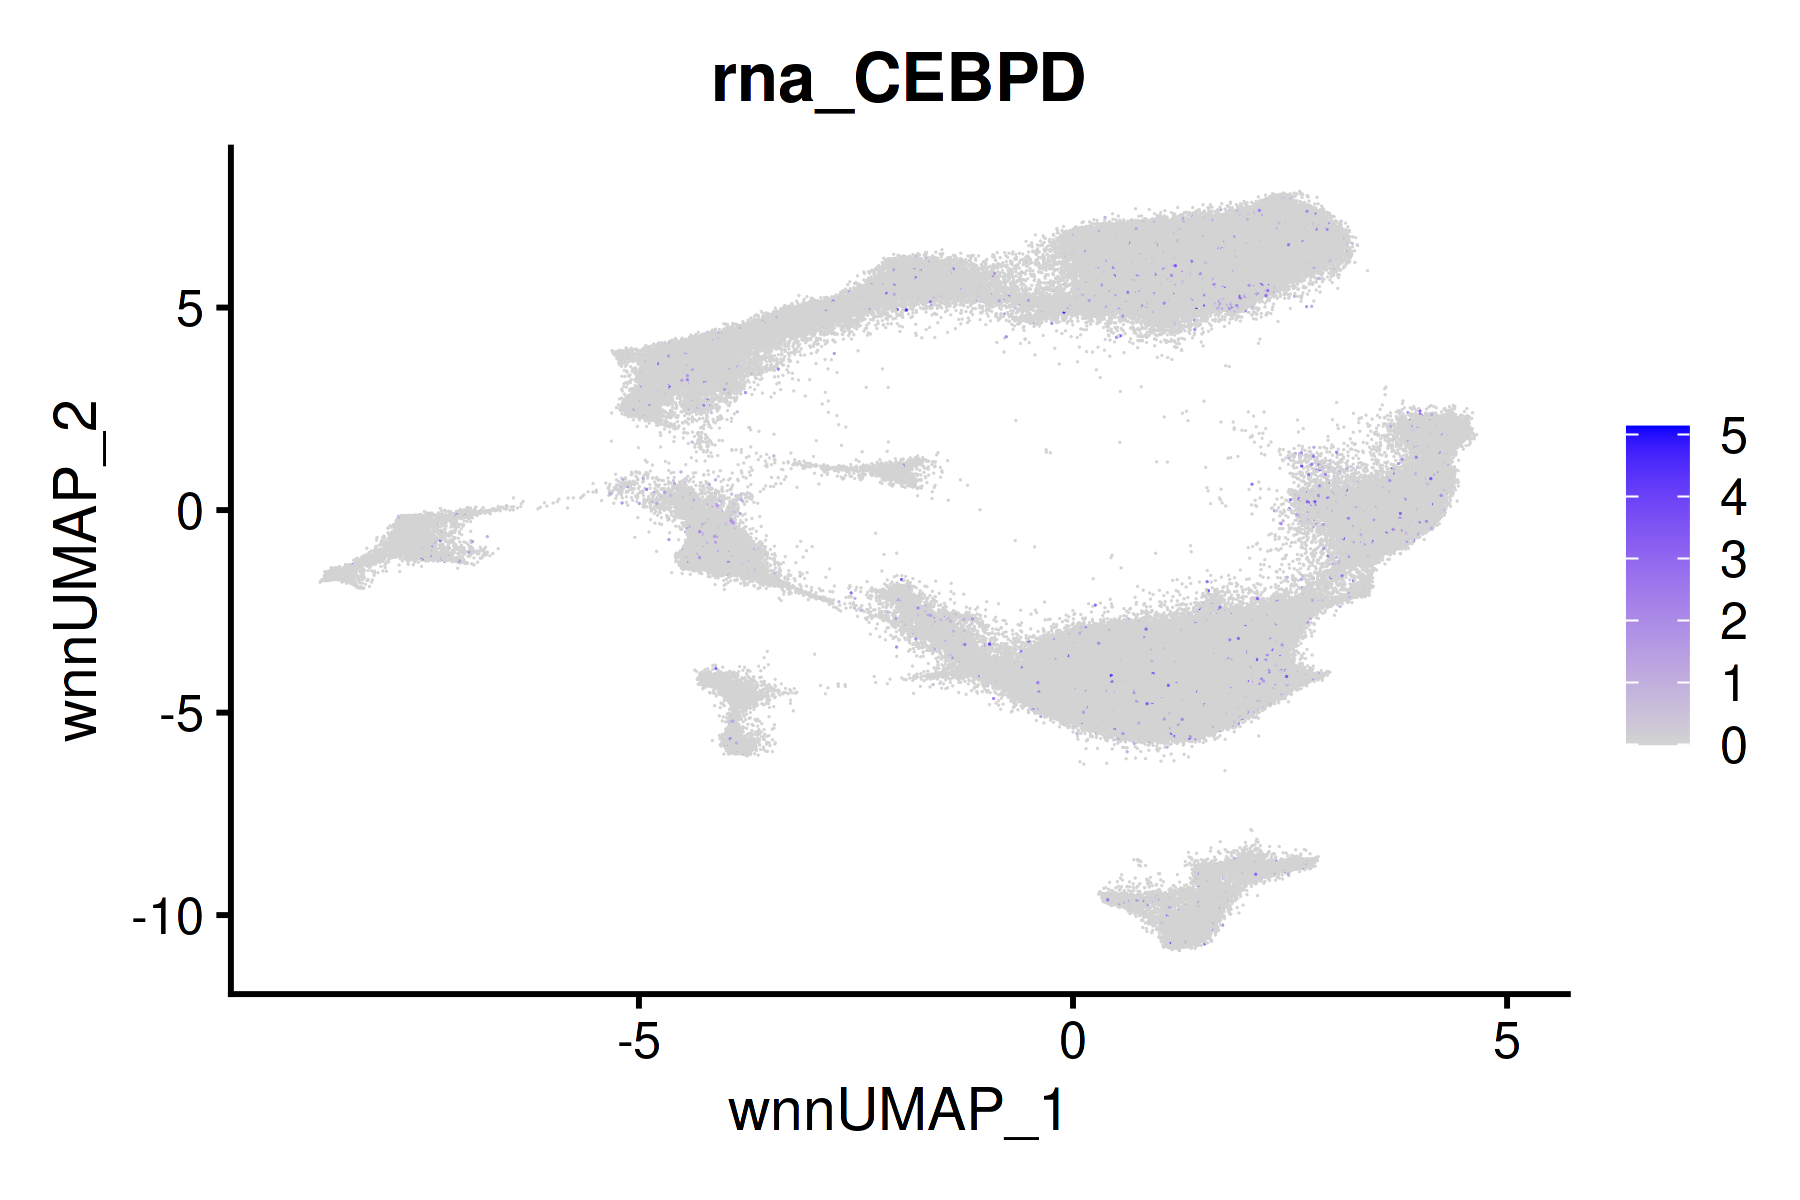

In [262]:
FeaturePlot(novaseq, features = "CEBPD", reduction = 'WNN.UMAP', pt.size = 0.1, raster = F)

### test feature plot

Warning message:
“Could not find CEBPD in the default search locations, found in RNA assay instead”
Warning message:
“Could not find MA0836.2 in the default search locations, found in chromvar assay instead”


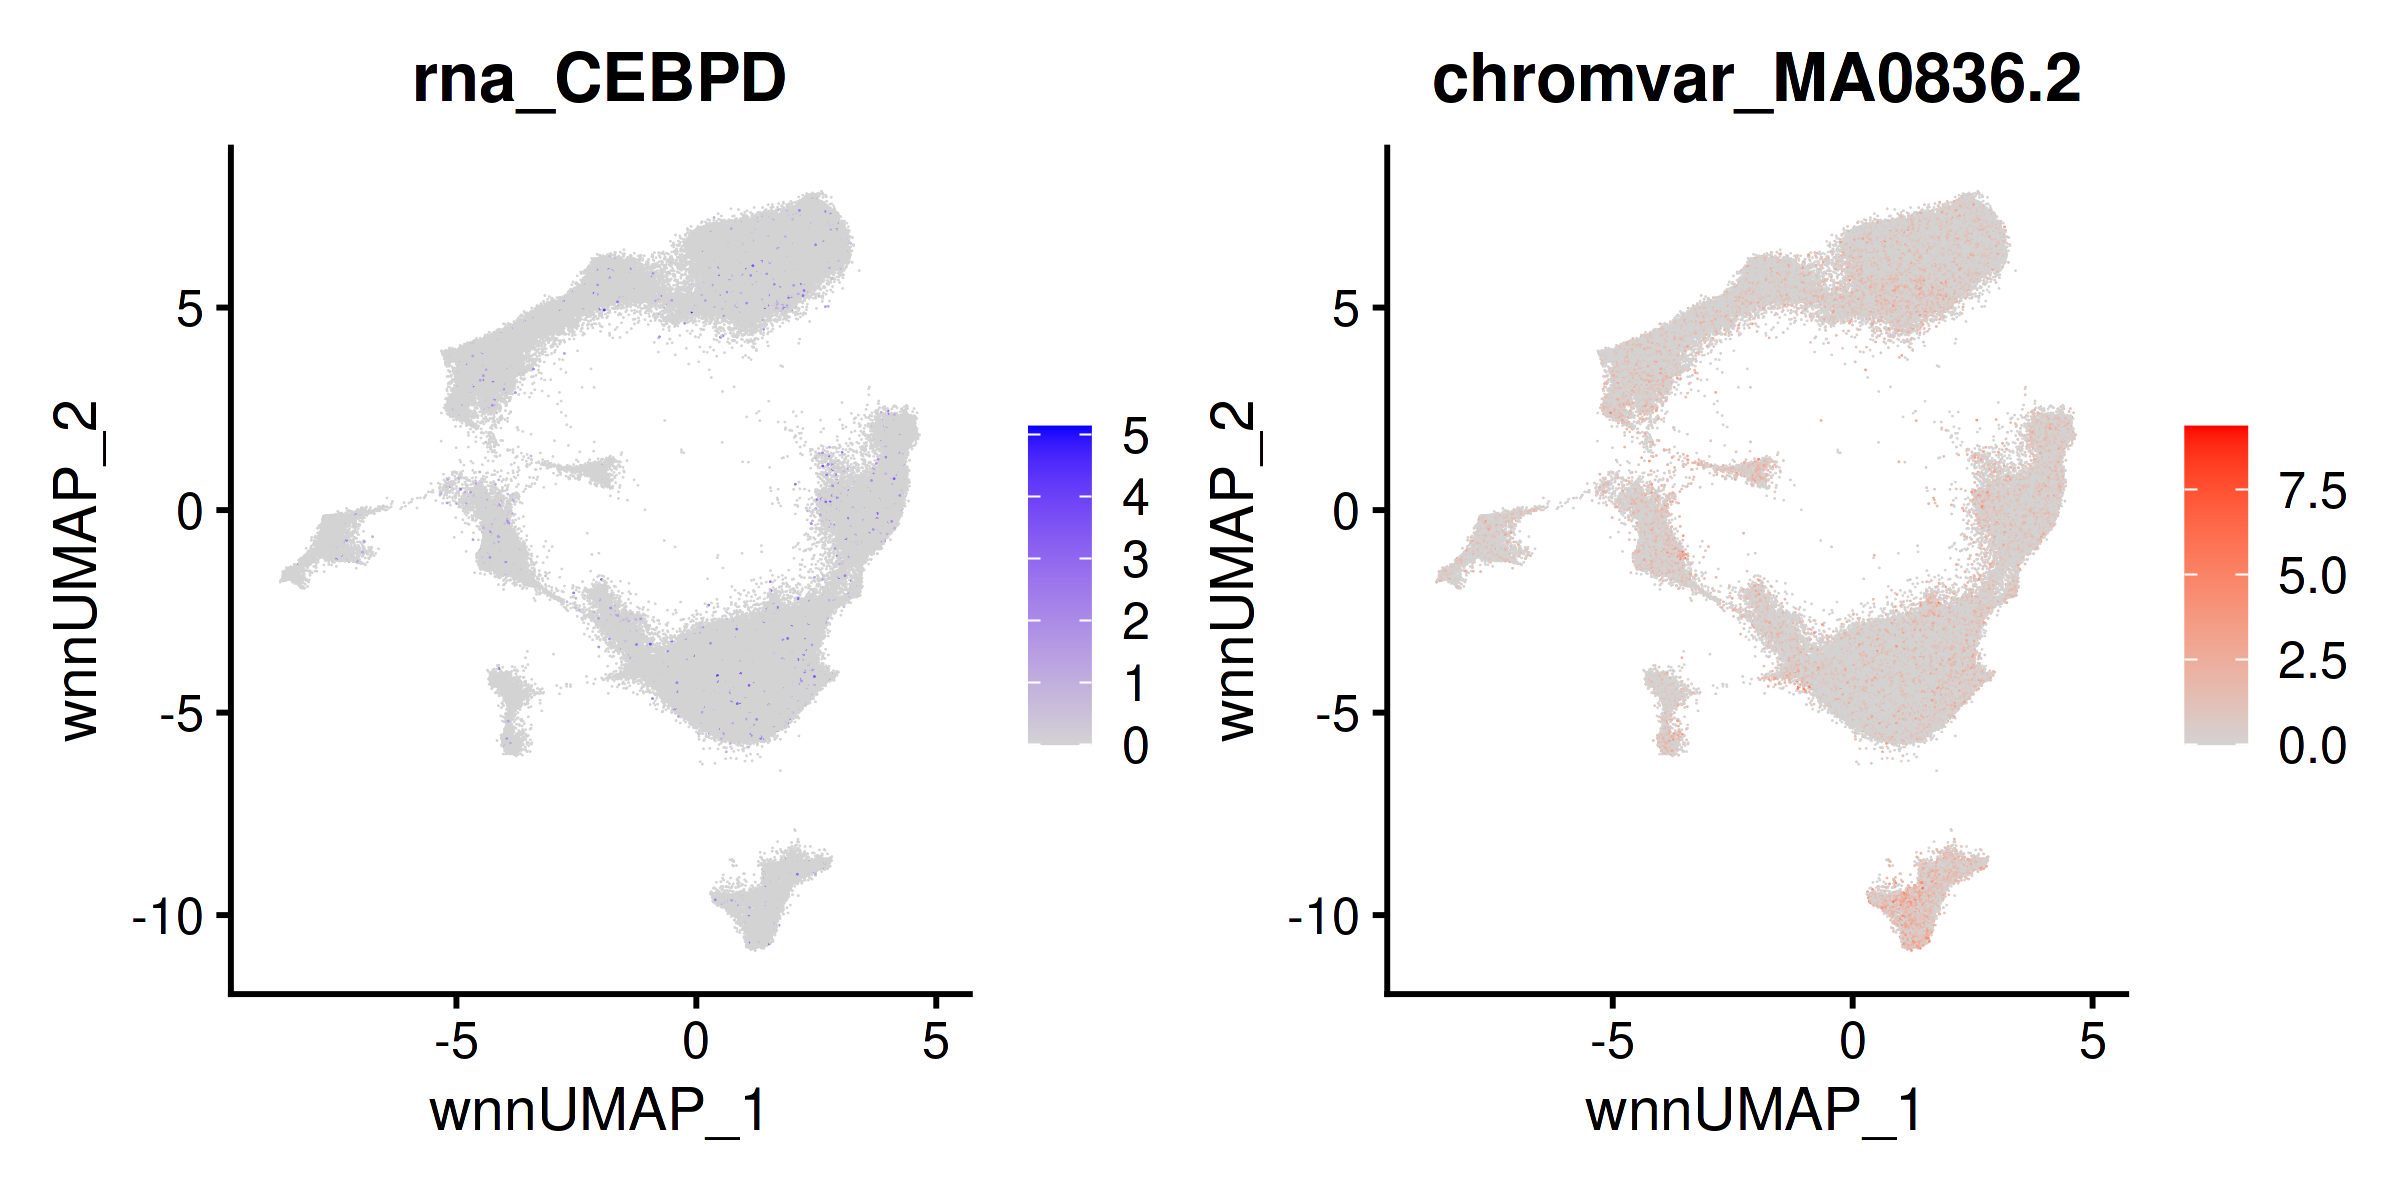

In [263]:
library(repr)
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 300)

#returns MA0836.2
motif.name <- ConvertMotifID(novaseq, name = 'CEBPD')
gene_plot <- FeaturePlot(novaseq, features = "CEBPD", reduction = 'WNN.UMAP', pt.size = 0.05, raster = F)
motif_plot <- FeaturePlot(novaseq, features = motif.name, min.cutoff = 0, cols = c("lightgrey", "red"), reduction = 'WNN.UMAP', pt.size = 0.05, raster = F)
gene_plot | motif_plot

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



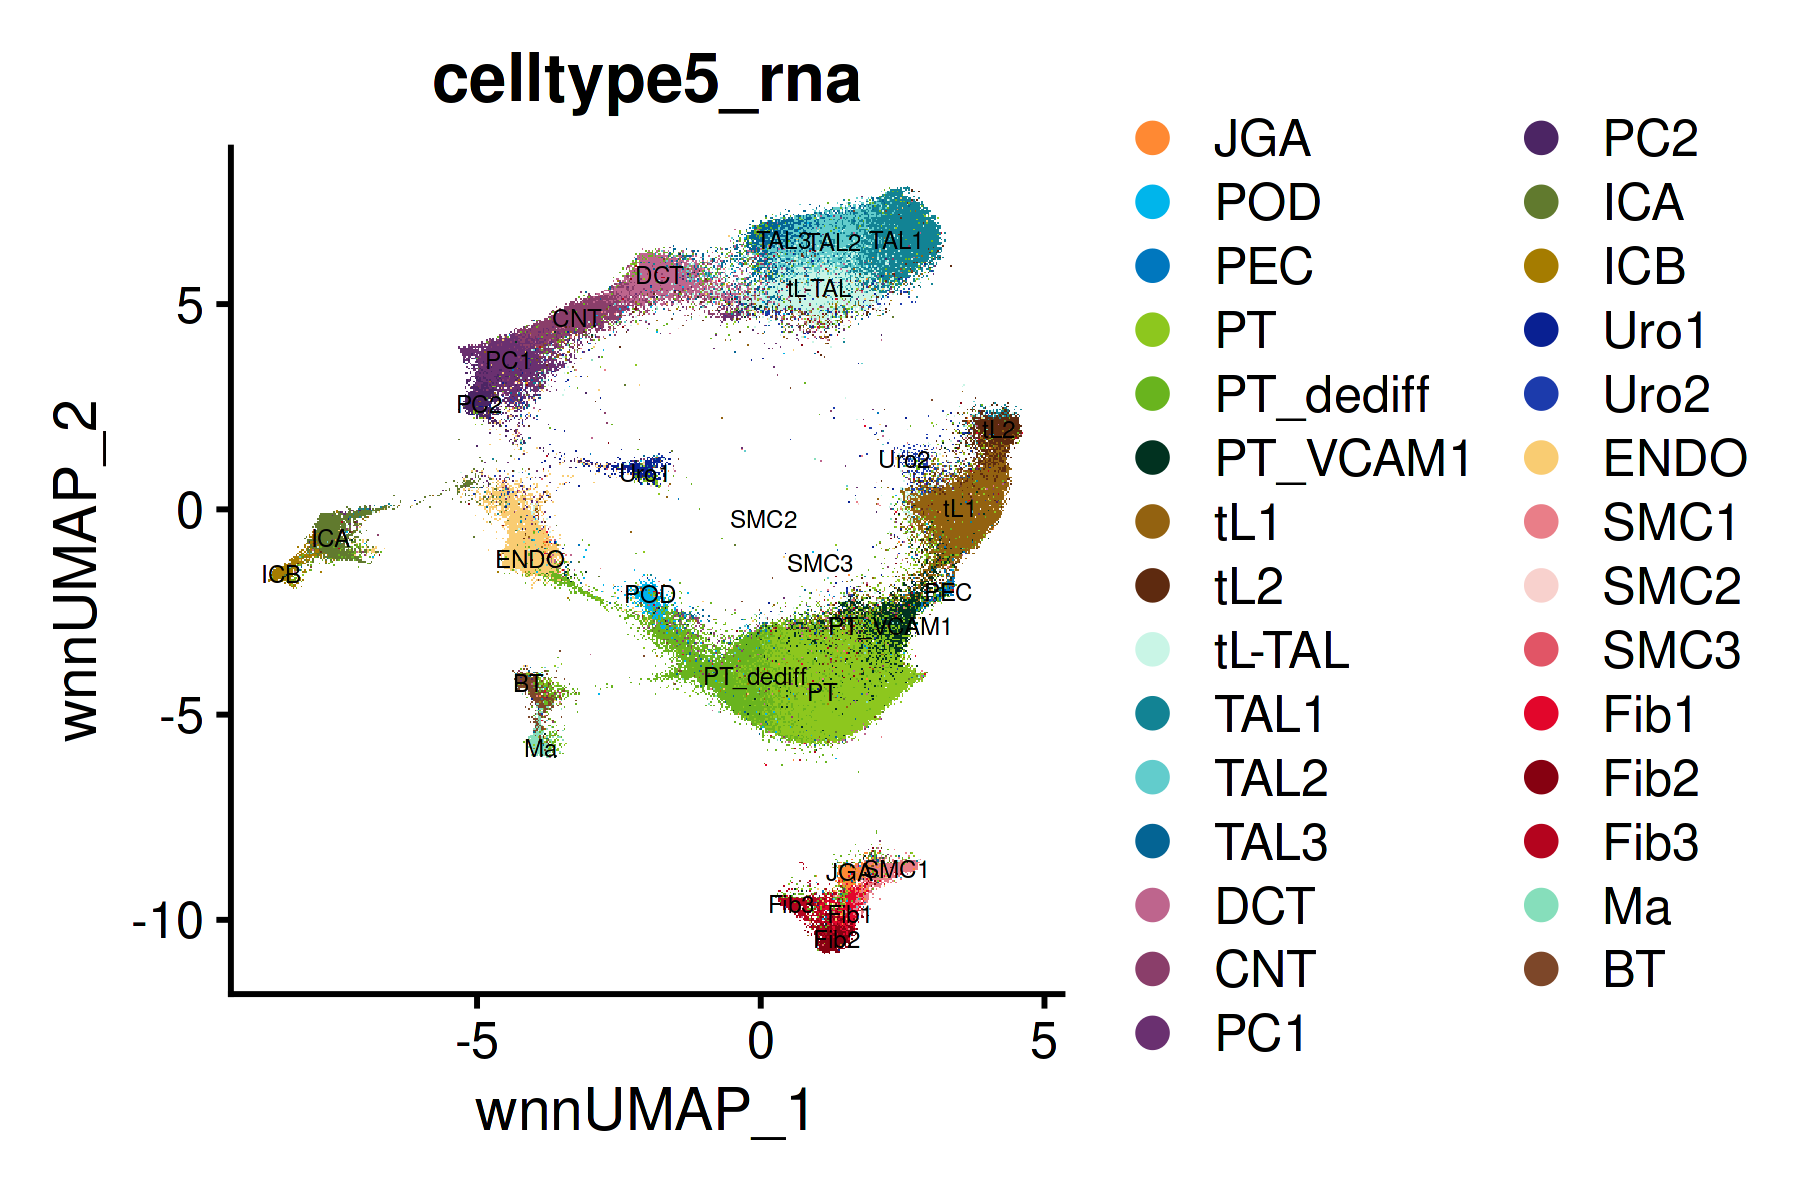

In [253]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)
DimPlot(novaseq, group.by = "celltype5_rna", reduction = 'WNN.UMAP', raster = T, pt.size = 0.2, 
        cols = palette.novaseq.rna, label = T, label.size = 2)

In [291]:
motif.name <- ConvertMotifID(novaseq, name = list_use$gene)

In [292]:
motif.name
list_use

[1] "MA0114.4" "MA0484.2" NA         "MA0066.1" NA         "MA0592.3" "MA0160.1"
[8] "MA0836.2"

gene,max_rna,max_motif
<chr>,<dbl>,<dbl>
HNF4A,3,3
HNF4G,3,3
PPARA,3,3
PPARG,3,3
ESRRG,3,3
ESRRA,3,3
NR4A2,3,3
CEBPD,3,3


In [77]:
firstup <- function(x) {
  paste0(toupper(substr(x, 1, 1)), tolower(substr(x, 2, nchar(x))))
}

In [294]:
for (i in 1:dim(list_use)[1]){
    gene_name = list_use$gene[i]
    print(gene_name)
    
    motif.name <- ConvertMotifID(novaseq, name = gene_name)
    
    if(is.na(motif.name)){
        gene_name = firstup(gene_name)
        motif.name <- ConvertMotifID(novaseq, name = gene_name)
        
        if(is.na(motif.name)) next
    }
    
    print(motif.name)
    
    gene_plot <- FeaturePlot(novaseq, features = list_use$gene[i], min.cutoff = 0, max.cutoff = list_use$max_rna[i], reduction = 'WNN.UMAP', pt.size = 0.001, raster = F)
    motif_plot <- FeaturePlot(novaseq, features = motif.name, min.cutoff = 0, max.cutoff = list_use$max_motif[i], cols = c("lightgrey", "red"), reduction = 'WNN.UMAP', pt.size = 0.001, raster = F)
    p = gene_plot | motif_plot

    filename = file.path(plots_dir, paste0(list_use$gene[i], ".png"))
    ggsave(filename = filename, plot = p, width = 8, height = 4, units = "in", dpi = 300)
}

[1] "HNF4A"
[1] "MA0114.4"


Warning message:
“Could not find HNF4A in the default search locations, found in RNA assay instead”
Warning message:
“Could not find MA0114.4 in the default search locations, found in chromvar assay instead”


[1] "HNF4G"
[1] "MA0484.2"


Warning message:
“Could not find HNF4G in the default search locations, found in RNA assay instead”
Warning message:
“Could not find MA0484.2 in the default search locations, found in chromvar assay instead”


[1] "PPARA"
[1] "PPARG"
[1] "MA0066.1"


Warning message:
“Could not find PPARG in the default search locations, found in RNA assay instead”
Warning message:
“Could not find MA0066.1 in the default search locations, found in chromvar assay instead”


[1] "ESRRG"
[1] "MA0643.1"


Warning message:
“Could not find ESRRG in the default search locations, found in RNA assay instead”
Warning message:
“Could not find MA0643.1 in the default search locations, found in chromvar assay instead”


[1] "ESRRA"
[1] "MA0592.3"


Warning message:
“Could not find ESRRA in the default search locations, found in RNA assay instead”
Warning message:
“Could not find MA0592.3 in the default search locations, found in chromvar assay instead”


[1] "NR4A2"
[1] "MA0160.1"


Warning message:
“Could not find NR4A2 in the default search locations, found in RNA assay instead”
Warning message:
“Could not find MA0160.1 in the default search locations, found in chromvar assay instead”


[1] "CEBPD"
[1] "MA0836.2"


Warning message:
“Could not find CEBPD in the default search locations, found in RNA assay instead”
Warning message:
“Could not find MA0836.2 in the default search locations, found in chromvar assay instead”


In [64]:
ConvertMotifID(novaseq, name = "PPARA::RXRA")

[1] "MA1148.1"

Warning message:
“Could not find PPARA in the default search locations, found in RNA assay instead”
Warning message:
“Could not find RXRA in the default search locations, found in RNA assay instead”
Warning message:
“Could not find MA1148.1 in the default search locations, found in chromvar assay instead”


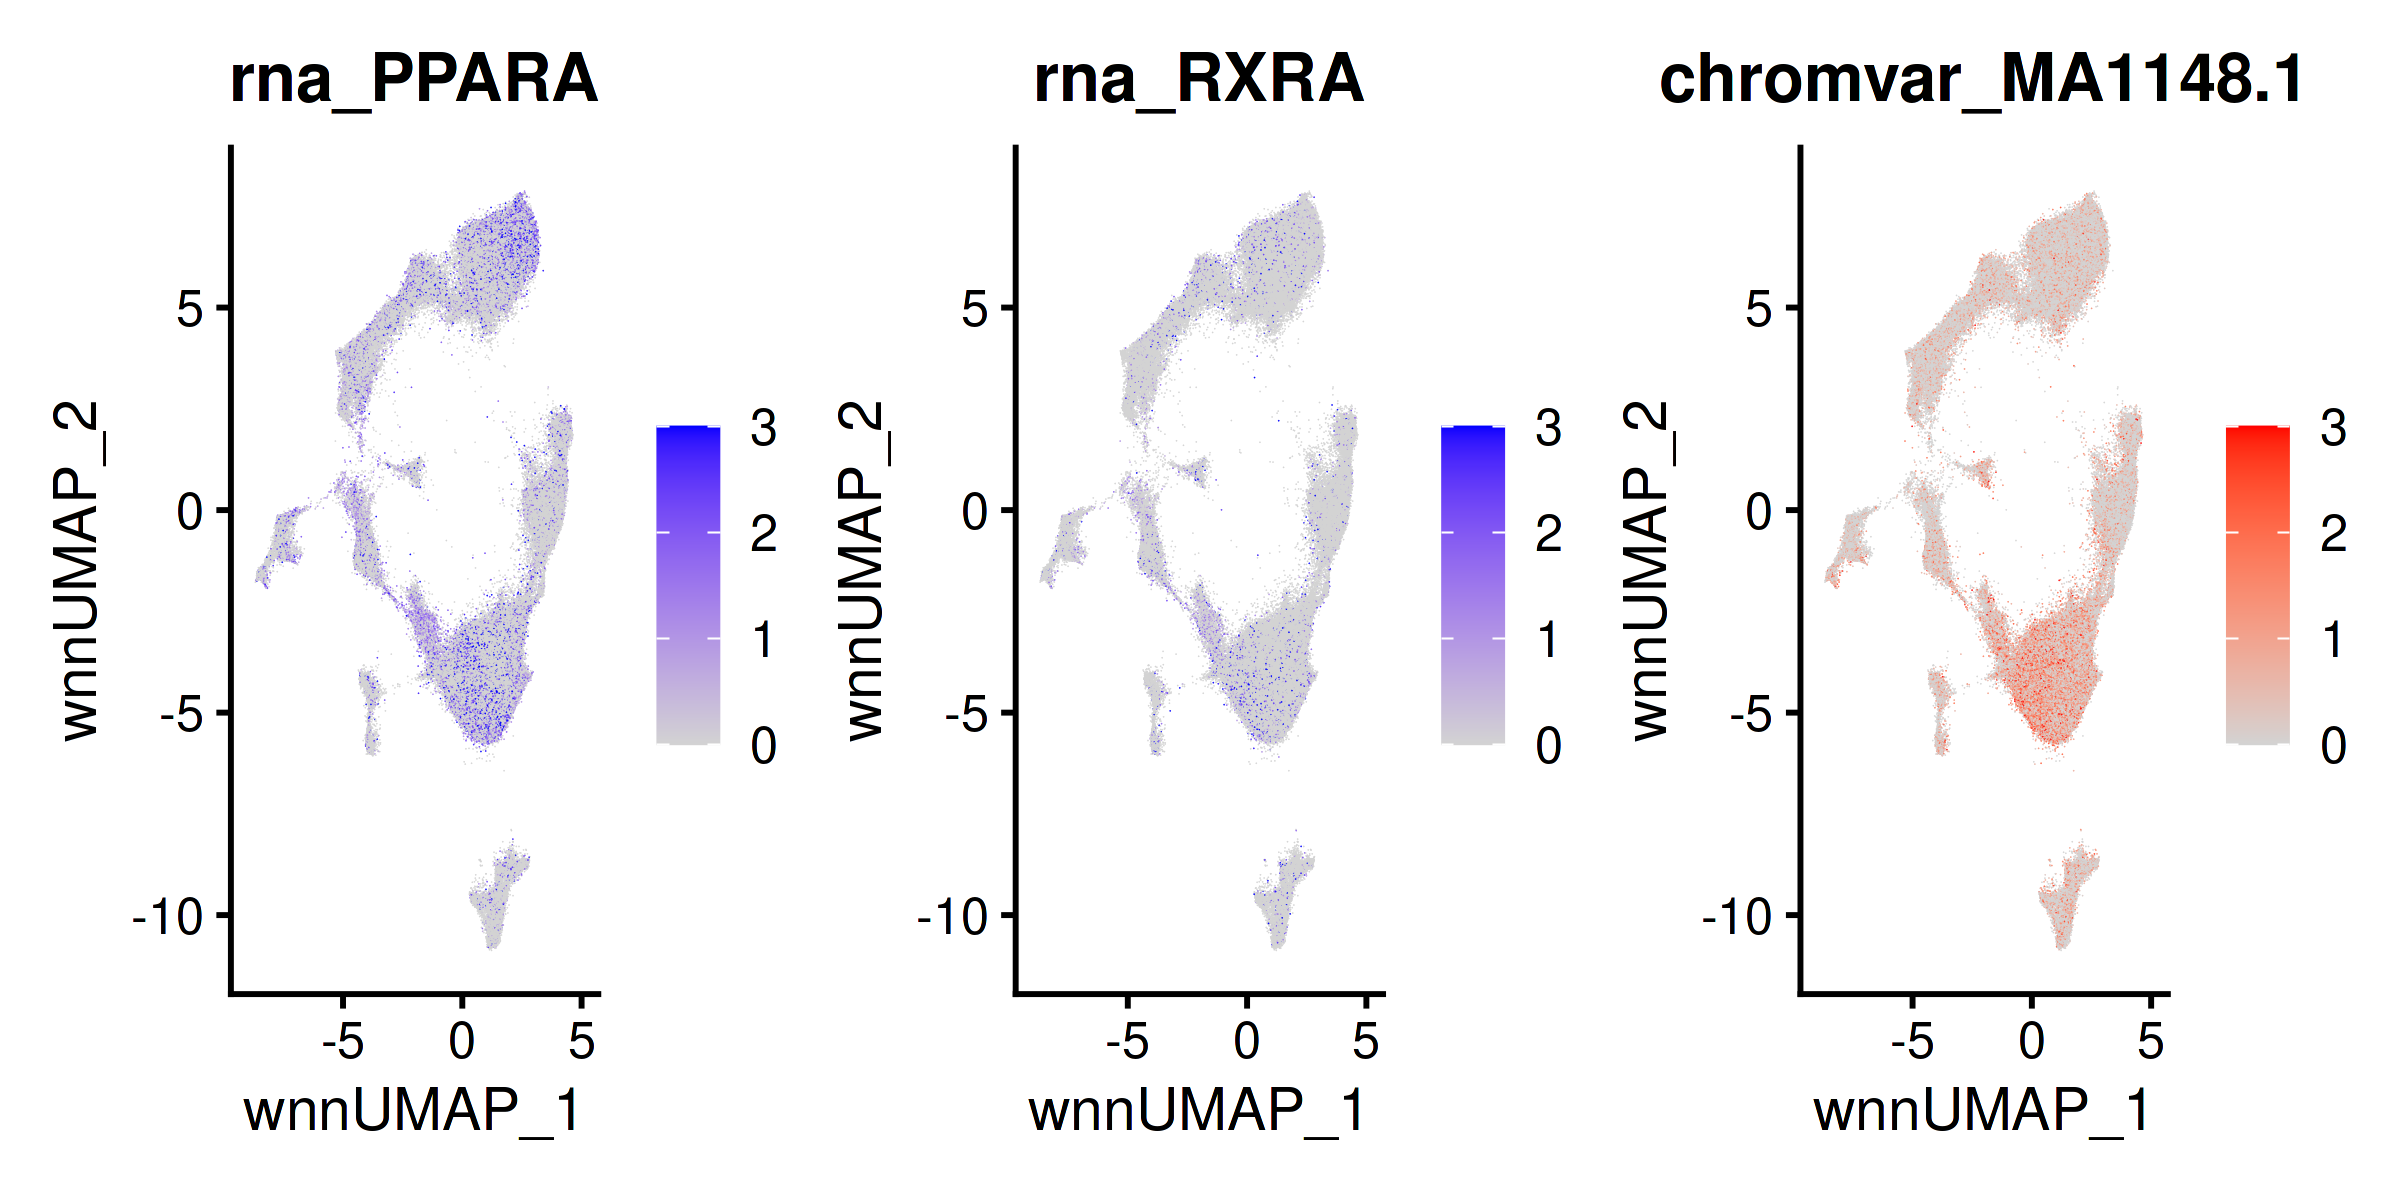

In [295]:
gene_plot <- FeaturePlot(novaseq, features = "PPARA", min.cutoff = 0, max.cutoff = 3, reduction = 'WNN.UMAP', pt.size = 0.001, raster = F)
gene_plot2 <- FeaturePlot(novaseq, features = "RXRA", min.cutoff = 0, max.cutoff = 3, reduction = 'WNN.UMAP', pt.size = 0.001, raster = F)
motif_plot <- FeaturePlot(novaseq, features = "MA1148.1", min.cutoff = 0, max.cutoff = 3, cols = c("lightgrey", "red"), reduction = 'WNN.UMAP', pt.size = 0.001, raster = F)
p = gene_plot | gene_plot2 | motif_plot
p = p + geom_point(size=0.5)
p
filename = file.path(plots_dir, paste0("PPARA::RXRA", ".png"))
ggsave(filename = filename, plot = p, width = 12, height = 4, units = "in", dpi = 300)